In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from typing import Callable, Tuple

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller

import utils


widget_sales = pd.read_csv('data/widget_sales.csv')
widget_sales.columns = ['sales']
widget_sales.head()

,sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


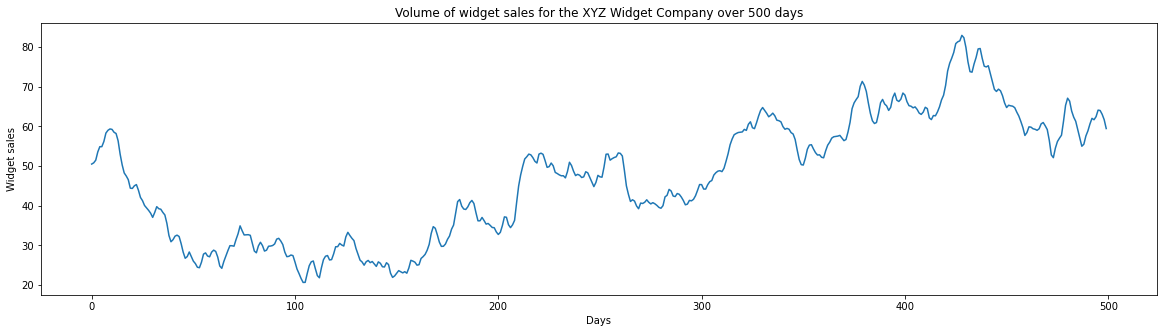

In [46]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(widget_sales.sales);
ax.set_xlabel('Days')
ax.set_ylabel('Widget sales')

plt.title('Volume of widget sales for the XYZ Widget Company over 500 days')
plt.show()

### Find the number of differencing need to make for stationarity

In [47]:
d = 0
data_to_test_adf = widget_sales.copy()
while (True):
    adf_test = adfuller(data_to_test_adf['sales'], maxlag=30)
    print(adf_test)
    if adf_test[1] < 0.05:
        break
    else: 
        data_to_test_adf['sales'] = data_to_test_adf['sales'].diff()
        data_to_test_adf.dropna(inplace=True)   
        d = d + 1

del data_to_test_adf
print(d)

(-1.5121662069359012, 0.5274845352272624, 3, 496, {'1%': -3.4436029548776395, '5%': -2.867384756137026, '10%': -2.5698830308597813}, 1323.9593425653406)
(-10.576657780341952, 7.076922818587599e-19, 2, 496, {'1%': -3.4436029548776395, '5%': -2.867384756137026, '10%': -2.5698830308597813}, 1318.5696276500776)
1


### Create test and training sets

In [57]:
test_set_size = int(0.1 * widget_sales.shape[0]) # one week worth for forecasting

df = widget_sales.copy()

train = df[:-test_set_size]
test = df[-test_set_size:]

print(len(train))
print(len(test))

450
50


### Create the optimize_arima function that returns the arima order and the aic sorted in descending order

In [58]:
def optimize_arima(ser : pd.Series, p_max : int = 4, q_max : int = 4, i : int = 1):
    ps = range(0, p_max)
    qs = range(0, q_max)
    combinations = product(ps, qs)
    
    arr = []
    for o in combinations:
        try:
            model = ARIMA(ser, order=(o[0], i, o[1])).fit()        
            arr.append((o, model.aic, model.sse))
        except:
            continue
    
    res = pd.DataFrame(arr, columns=['order', 'aic', 'sse'])
    res.sort_values(by=['aic'], inplace=True)
    
    return res

In [59]:
optimal_arima_df = optimize_arima(train.sales, i=1)
optimal_arima_df.head()

/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,order,aic,sse
15,"(3, 3)",1251.425168,2962.858622
2,"(0, 2)",1254.409302,2973.268161
9,"(2, 1)",1254.961827,2971.872043
3,"(0, 3)",1255.826822,2972.700299
12,"(3, 0)",1255.967595,2972.818480


### We pick the best performing order and use the order

In [72]:
arima_order = (0, d, 2)
arima_model = ARIMA(train.sales, order=arima_order).fit()
res = arima_model.resid
print(arima_model.aic, arima_model.sse)

1254.4093019059565 2973.2681614664325


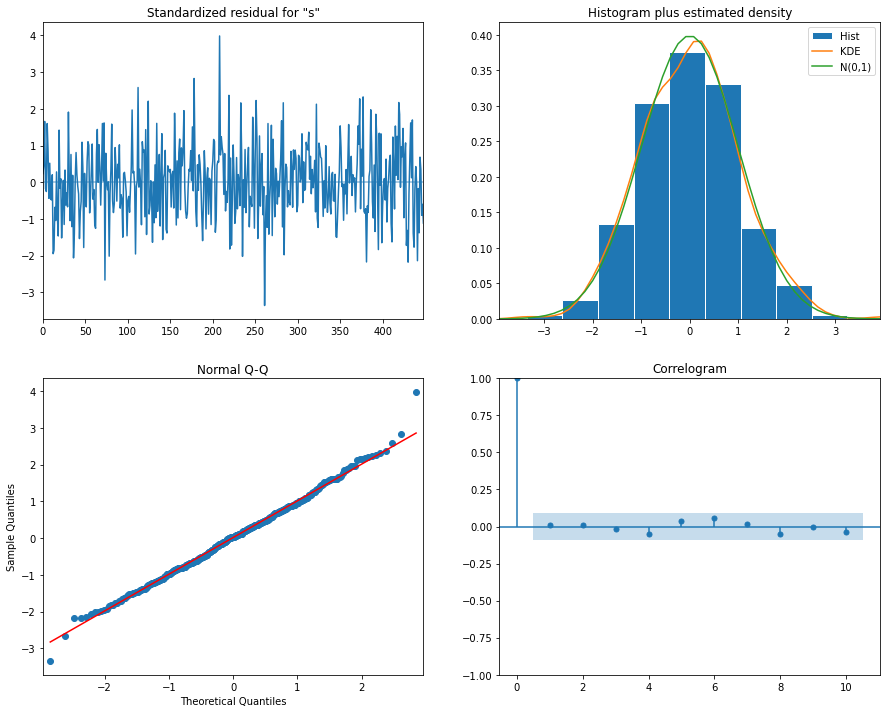

In [73]:
arima_model.plot_diagnostics(figsize=(15, 12));

In [88]:
ljungbox_test_df = acorr_ljungbox(arima_model.resid, np.arange(1, 11, 1))
auto_corr_test = np.sum(ljungbox_test_df.loc[:, 'lb_pvalue'].values < 0.05)
print('Residuals is a white noise' if auto_corr_test == 0 else 'Residuals is autocorrelated')

Residuals is a white noise


### 6.6 Forecasting sales using rolling prediction

In [74]:
def arima_predict_function(arr, arma_order, window):
    arima = ARIMA(arr, order=arma_order)
    fit = arima.fit()
    return fit.get_forecast(steps=window).predicted_mean

total_len = widget_sales.shape[0]
train_len = train.shape[0]
window = 2

test.loc[:, 'predicted_sales'] = utils.pd_rolling_forecast(
    widget_sales.sales, total_len, train_len, window, 'ARMA', arima_order, arima_predict_function)

/var/folders/xl/w9y4tjx938vdwtkgzwxsxx8m0000gp/T/ipykernel_34269/2916767281.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'predicted_sales'] = utils.pd_rolling_forecast(


In [75]:
test.head()

,sales,predicted_sales
450,64.736005,64.827303
451,65.316972,64.553995
452,65.172070,66.098195
453,65.075506,66.333164
454,64.703173,65.244500


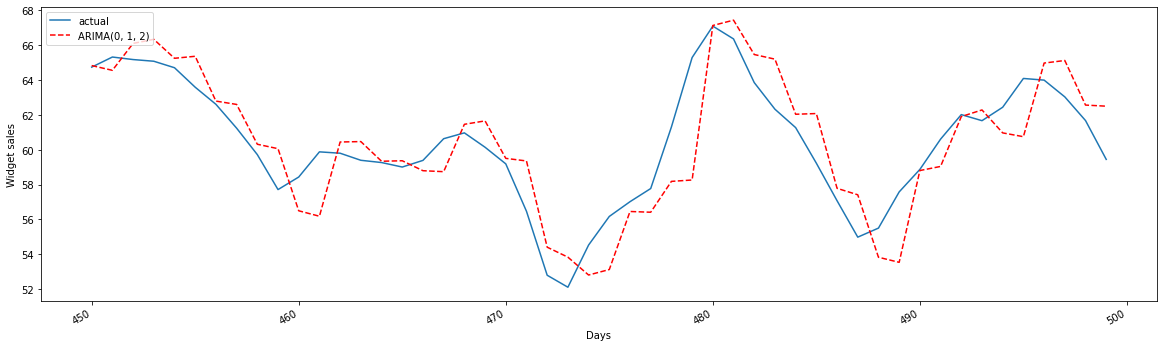

In [76]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(test.sales, label='actual')
ax.plot(test.predicted_sales, 'r--', label=f'ARIMA{arima_order}')
ax.legend(loc=2)

ax.set_xlabel('Days')
ax.set_ylabel('Widget sales')

fig.autofmt_xdate()
plt.show()

In [77]:
mse_arima = mean_squared_error(test.sales, test.predicted_sales)
print(mse_arima)

4.10395770029629


In [80]:
mae_arima = mean_absolute_error(test.sales, test.predicted_sales)
print(mae_arima)

1.5547913804321722
